# Algorithm for MCDC with graph notation

## Description:
This notebook converts a decision (a combination of predicates) into a graph. This graph is used to visualize the test cases to fulfill the requirements of MCDC - Modified Condition Decision Coverage.

A testset that fulfills the requirements MCDC shows that every single condition is at least one time true and one time false in such a way that changing this single condition from true to false or from false to true changes the outcome of the decision in exactly the same way.

Although this method is called a whitebox test design technique and obviously can be used to test code and it can also be used to test high level requirements. This method can and is be used in several industries ranging from avionics, medicine technology, automotive and banking and insurance. In standards like RTCO-DO-178B (avionics) and ISO26262 (automotive) this method is explicitly mentioned, recommended and in some cases prescribed.

There are several methods to derive the MCDC test cases:
1. Brute force (cumbersome for larger - more than four conditions - decisions)
3. A technique where parenthesis are ignored and based on the sign of the connector the value of the conditions is determined
4. A technique where the potential test cases are separated in two columns and in every row only one condition is changed from true to false. At the end the duplicates are removed. This method is described in the book TMap Next
5. Translation of the decision into a graph where is shown that every true outcome is one path in the graph and corresponding false test case is the same path with only one node changed from true to false.

Some commercial tools using the first method and sometime the brute force method is presented as the only feasible way to get the right test cases. For method 2 and 4 are also tools available. Method 4 is in this notebook implemented, but also uses method 2 to show the different graphs for the positive and negative test cases.
Method 3 is often used by testers because although it takes some time and training the method can be mastered.
## Steps
The graphs are created with graphviz. This module can be installed with **pip install** or if anaconda is used with **conda install**. The latter didn't function for me, maybe some configuration problem. The notebook is written for **python3**.
1. Import the different modules
2. Set the standard format for graph files
3. Definition of functionality to add nodes and edges to the graph
4. Provide the decision
5. Analyze the decision and translate it into the graph by added the nodes and the edges
6. Print the graph and save the graph as 'png' image
7. Create the test cases and their corresponding graphs show them and save them

In [ ]:
import graphviz as gv
from IPython.display import display, Image
import functools
import re
from datetime import datetime
import os

In [ ]:
digraph = functools.partial(gv.Digraph, format='png')

### Functionality for adding nodes and edges to the graph

In [ ]:
def add_nodes(graph, nodes):
    for n in nodes:
        if isinstance(n, tuple):
            graph.node(n[0], **n[1])
        else:
            graph.node(n)
    return graph

In [ ]:
def add_edges(graph, edges):
    for e in edges:
        if isinstance(e[0], tuple):
            graph.edge(*e[0], **e[1])
        else:
            graph.edge(*e)
    return graph

## Functionality for adding nodes and connections
The decision is provided as a string and then seperated into single characters

In [ ]:
# add the predicates as nodes to a list
def list_nodes(decision, nodes):
    nodes = ['Start']
    for x in decision:
        if re.match(r"[A-Za-z]", x):
            nodes += x
    nodes += ['End']
    return nodes

In [ ]:
def add_connection(connections, a, b):
    # help function to build intermediate graph dictionary
    if a in connections:
        connections[a].append(b)
    else:
        ls = [b]
        connections[a]= ls

## Analysis of every character of the decision
The primary analysis of every single element of the decision. It is determined which elements have to be connected.

In [ ]:
def extract_edges(decision, connections):
    # extract the edges from the decision
    # due to the numerous possible orderings of the different predicates, booleans and parenthesis
    # this algorithm contains a lot of different conditionals
    orStack = list()
    andStack = list()
    previous = 'Start'
    sign = ''
    for i, elem in enumerate(decision):
        if elem == '&' or elem == '|':  
            #if sign: set sign
            sign = decision[i]
        elif elem == '(' and sign == '':  
            #if left parenthesis: connect parenthesis to previous element
            s1 = '(' + str(i)
            add_connection(connections, previous, s1)
            previous = s1
        elif re.match(r"[A-Za-z]", elem) and sign == '': 
            #if first condition: connect to previous element
            add_connection(connections, previous, elem)
            previous = elem
        elif re.match(r"[A-Za-z]", elem) and previous[0] == '(':
            # if previous element is left parenthesis: connect to previous element
            add_connection(connections, previous, elem)
            previous = elem
        elif (re.match(r"[A-Za-z]", elem) or elem == '(') and sign == '&':
            # connect to previous condition
            # if previous condition is within parenthesis connect to every condition that is
            # connected via 'or' to the next condition
            # the traverse of the parenthesis (in the direction left) is finished when the
            # left outer parenthesis is reached
            if elem == '(':
                s1 = elem + str(i)
            else:
                s1 = elem
            previous = s1
            if decision[i-1] == '(':
                add_connection(connections, '(' + str(i-1), s1)
            elif re.match(r"[A-Za-z]", decision[i-2]):
                add_connection(connections, decision[i-2], s1)
            else:
                back = 2
                first = True # first step into parenthesis
                while i - back >= 0:
                    if decision[i - back] == ')': 
                        # entering one nesting deeper
                        andStack.append(')')
                    elif re.match(r"[A-Za-z]", decision[i - back]) and first: 
                        # connect to the first condition from the rigt
                        add_connection(connections, decision[i - back], s1)
                        first = False
                    elif re.match(r"[&, |]", decision[i - back]): 
                        #set sign
                        sign = decision[i - back]
                    elif re.match(r"[A-Za-z]", decision[i - back]) and sign == '|': 
                        # connect if connection is 'or'
                        add_connection(connections, decision[i - back], s1)
                    elif decision[i - back] == '(':
                        andStack.pop()
                        if not andStack:
                            break # stop when outer left parenthesis is reached
                    back += 1

        elif (re.match(r"[A-Za-z]", elem) or elem == '(') and sign == '|':
            # traverse the decision backwards till point where connection is adequate, 
            # without paranthesis this means the start
            # with paranthesis this means the left paranthesis
            if elem == '(':
                s1 = elem + str(i)
            else:
                s1 = elem
            previous = s1
            if decision[i-1] == '(':
                add_connection(connections, '(' + str(i-1), s1)
            else:
                back = 2
                while i - back >= 0:
                    if i - back == 0:
                        if decision[0] == '(':
                            connect = '(0'
                        else:
                            connect = 'Start'
                        add_connection(connections, connect, s1)
                    elif decision[i - back] == ')':
                        # entering one nesting deeper
                        orStack.append(')')
                    elif decision[i - back] == '(':
                        if not orStack:
                            add_connection(connections, '(' + str(i - back), s1)
                            break
                        else:
                            orStack.pop()
                    back += 1
    return connections

In [ ]:
def sanatize(dic):
    # removes the '(' as key and replaces it with the real connections
    for k, v in dic.items():
        connect(dic, k, k,  v)
    for k in list(dic.keys()):
        if re.match(r"[(]", k) != None:
            del dic[k]
        else:
            dic[k] = list(filter(lambda x: re.match(r"[(]", x) == None, dic[k]))

In [ ]:
def connect(dic, start, k, v):
    # connects the appropriate nodes
    if re.match(r"[(]", v[0]) != None:
        connect(dic, start, v[0], dic[v[0]])
        if len(v) > 1:
            connect(dic, start, k, v[1:])
    elif len(v) > 1:
        connect(dic, start, k, v[1:])
        connect(dic, start, k , v[0])
    elif v[0] not in dic[start]:
        dic[start].append(v[0])

## Create graph

In [ ]:
def create_decision_graph(decision):
    g1 = digraph()
    decision = list(decision)
    nodes = list()
    connections= {}

    sanatize(extract_edges(decision, connections))
    nodes = list_nodes(decision, nodes)
    edges = list()

    for k, v in connections.items():
        for x in v:
            edges.append((k, x))

    for node in nodes:
        if node not in connections.keys() and node != 'End':
            edges.append((node, 'End'))
    add_edges(g1, edges)
    return g1

## Decision solver

In [ ]:
class Condition:
    def __init__(self):
        self.name = ''
        self.precop = ''
        self.trailop = ''

In [ ]:
class Testcase:
    def __init__(self, seq, res):
        self.seq = seq
        self.res = res

In [ ]:
class Decision:
    def __init__(self):
        self.conditions = list()
        self.testcases = list()
        
    def extract(self, raw):
        elem = list(raw)
        size = len(raw)
        i = 0
        while i < size:
            temp = Condition()
            temp.name = elem[i]
            if i == 0:
                temp.precop = '-'
            else:
                temp.precop = elem[i-1]
            if (i+1) == size:
                temp.trailop = '-'
            else:
                temp.trailop = elem[i+1]
            self.conditions.append(temp)
            i += 2
    
    def derivation(self):
        length = len(self.conditions)
        self.testcases = [None] * length
        testcase = list()
        for i in range(0, len(self.conditions)):
            for x in range(0, length - (length - i)):
                if self.conditions[x].trailop == "&":
                    testcase.append("1")
                else:
                    testcase.append("0")
            testcase.append("1")
            for x in range(i+1, length):
                if self.conditions[x].precop == "&":
                    testcase.append("1")
                else:
                    testcase.append("0")
            self.testcases[i] = Testcase(''.join(testcase), "True")
            testcase[i]=("0")
            self.testcases.append(Testcase(''.join(testcase), "False"))
            testcase.clear()
    
    def reduce(self):
        li = list()
        temp = list()
        for testcase in self.testcases:
            if testcase.seq not in li:
                li.append(testcase.seq)
                temp.append(testcase)
        self.testcases.clear()
        self.testcases = temp
        
    def print_testcases(self):
        i = 1
        for x in self.testcases:
            print('Testcase ' + str(i) + ': ' + x.seq + '   ' + x.res)
            i += 1

    def write_file(self, fileName):

        with open(fileName, mode='w', encoding='utf8') as resFile:
            i = 1
            conditions = ''
            for cond in self.conditions:
                conditions += cond.name
            resFile.write("             " + conditions + '\n')
            for x in self.testcases:
                resFile.write('Testcase {0:>2d}: {1}  {2}\n'.format(i, x.seq, x.res))
                i += 1

## Proof of Correctness Decision
The layout of the decision is checked and if the layout isn't correct the reason is printed together with the supplied decision and the application raises an exception.

In [ ]:
class DecisionError(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

In [ ]:
def proof_decision(sequence):
    try:
        if len(sequence) == 0:
            raise DecisionError('No conditions')
        
        if len(sequence) == 1:
            if re.match(r"[^A-Za-z]", sequence):
                raise DecisionError('No conditions')

        if re.match(r"^[^A-Za-z(]", sequence):
            raise DecisionError('Wrong start character')
        
        if re.match(r'.+[^A-Za-z)]$', sequence):
            raise DecisionError('Wrong termination character')
        
        if re.match(r".*\([^A-Za-z(]", sequence):
            raise DecisionError('Wrong "(" sequence')

        if re.match(r".+\)[^)&|]", sequence):
            raise DecisionError('Wrong ")" sequence')
        
        if re.match(r".*[A-Za-z][A-Za-z]", sequence):
            raise DecisionError('Condition condition sequence')
        
        if re.match(r".+[\s]+", sequence):
            raise DecisionError('Blanks')
        ##
        
        if re.match(r".+[^A-Za-z()&|]", sequence):
            raise DecisionError('Illegal character')
                                
        seq = re.sub('[\(\)]', '', sequence)
        seq_split = re.split("\||\&", seq)
        if len(seq_split) != len(set(seq_split)):
            raise DecisionError('Duplicate letters')
 
        parentheses_check(sequence)
        
    except DecisionError as e:
        if e.value == 'No conditions':
            print('Decision has to contain at least one condition!')
        if e.value == 'Wrong start character':
            print('The decision has to start with a letter or "("')
        if e.value == 'Wrong termination character':
            print('The decision has to en with a letter or ")"')
        if e.value == 'Wrong "(" sequence':
            print('The "(" sign has to be followed by a letter or "("')
        if e.value == 'Wrong ")" sequence':
            print('The ")" sign has to be followed by a "&" or "|" or ")" or should end the decision')
        if e.value == 'Condition condition sequence':
            print('The decision contains two conditions that are not seperated by "&" or "|"')
        if e.value == 'Blanks':
            print('The decision contains white spaces')
        if e.value == 'Illegal character':
            print('The condition should only contains letters and "&", "|", "(", ")"')
        if e.value == 'Duplicate letters':
            print('A letter can only be used once within a decision')
        if e.value == 'Wrong parentheses sequence':
            print('The sequence of parentheses is not correct')
        print("The sequence was: " + sequence)
        raise
    

In [ ]:
#check on the right sequence of parentheses
def parentheses_check(sequence):
    stack = list()
    paren = list(filter((lambda x: re.match(r"[()]", x) != None), list(sequence)))
    for parenthesis in paren:
        if parenthesis == "(":
            stack.append(parenthesis)
        elif not stack:
            raise DecisionError('Wrong parentheses sequence')
            break
        else:
            stack.pop()
    if stack:
        raise DecisionError('Wrong parentheses sequence')
                

In [ ]:
def solve_decision(sequence):
    decision = Decision()
    decision.extract(sequence)
    decision.derivation()
    decision.reduce()
    return decision

In [ ]:
def solve_and_visualize(sequence):
    seq = sequence
    
    #check correctness of decision
    proof_decision(seq)
 
    
    #create decision graph
    dg = digraph()
    dg = create_decision_graph(seq)
    
    #strip the parentheses of the sequence
    seq = re.sub('[()]', '', seq)
    
    #solve decision
    decision = solve_decision(seq)
    
    #create directory with timestamp
    now = datetime.now()
    stamp = re.sub('[-\.: ]', '', str(now))
    os.mkdir(stamp)
    
    #save results
    decision.write_file(stamp + '/res.txt')
    
    #visualize solution
    nodes = list()
    for x in seq:
        if re.match(r"[a-z, A-Z]", x):
            nodes.append(x)

    for a, test in enumerate(decision.testcases):
        for i, elem in enumerate(test.seq):
            if elem == '0':
                paint = 'red'
            else:
                paint = 'green'
            dg.node(nodes[i], color = paint, style = 'filled')
        if test.res == 'True':
            paint = 'green'
        else:
            paint = 'red'
        dg.node("End", color = paint, style = 'filled')
        dg.render(stamp + '/img/dg' + str(a))

    for x, elem in enumerate(decision.testcases):
        display(Image(filename= stamp + '/img/dg' + str(x)+ '.png', retina=True))
        elem.seq                
    

# Provide decision
The decision has to be provided as a string. It can contain parenthesis and the booleans '&' and '|'. As you see the signs are single. This is for conviences reasons - less input - and it also simplifies the algorithm.
Exclusive OR and negations are not accecpted. The negation is easy to avoid by translating the predicate afterwards into its negation. The predicates have to be replaced by letters by yourself and have to be translated back into their predicates when the analysis is finished.

In [ ]:
# give here the decision that must be analysed
solve_and_visualize('A&(B|C)')

# Tests

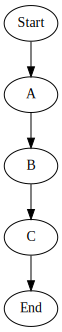

In [42]:
# Test 01:
# expected result: {'B': ['C'], 'A': ['B'], 'Start': ['A'], 'C': ['End']}
create_decision_graph('A&B&C')

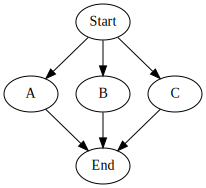

In [14]:
# Test 02:
# expected result: {'Start': ['A', 'B', 'C'], 'A': ['End'], 'B': ['End'], 'C': ['End']}
create_decision_graph('A|B|C')

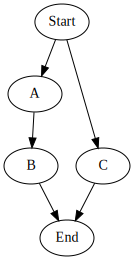

In [21]:
# Test 03:
# expected result: {'A': ['B'], 'Start': ['A', 'C'], 'B': ['End'], 'C': ['End']}
create_decision_graph('A&B|C')

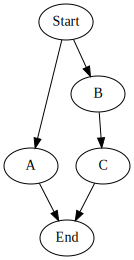

In [16]:
# Test 04:
# expected result: {'B': ['C'], 'Start': ['A', 'B'], 'A': ['End'], 'C': ['End']}
create_decision_graph('A|B&C')

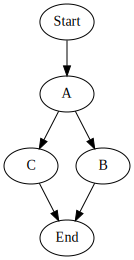

In [72]:
# Test 05:
# expected result: {'A': ['C', 'B'], 'Start': ['A'], 'B': ['End'], 'C': ['End']}
create_decision_graph('A&(B|C)')

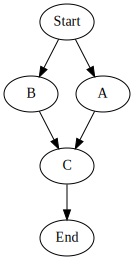

In [73]:
# Test 06:
# expected result: {'B': ['C'], 'A': ['C'], 'Start': ['B', 'A'], 'C': ['End']}
create_decision_graph('(A|B)&C')

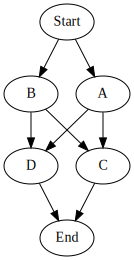

In [74]:
# Test 07:
# expected result: {'B': ['D', 'C'], 'A': ['D', 'C'], 'Start': ['B', 'A'], 'C': ['End'], 'D': ['End']}
create_decision_graph('(A|B)&(C|D)')

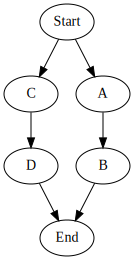

In [20]:
# Test 08:
# expected result: {'A': ['B'], 'Start': ['A', 'C'], 'C': ['D'], 'B': ['End'], 'D': ['End']}
create_decision_graph('A&B|C&D')

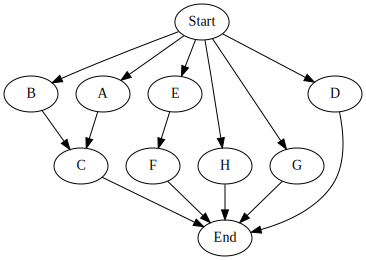

In [75]:
# Test 09:
# expected result: {'B': ['C'], 'A': ['C'], 'E': ['F'], 'Start': ['B', 'A', 'E', 'H', 'G', 'D'], 'C': ['End'],
#                   'D': ['End'], 'F': ['End'], 'G': ['End'], 'H': ['End']}
create_decision_graph('((A|B)&C)|D|(E&F|G)|H')

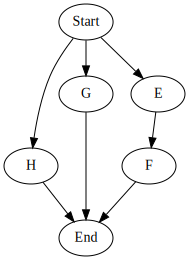

In [76]:
# Test 10:
# expected result: {'E': ['F'], 'Start': ['H', 'G', 'E'], 'F': ['End'], 'G': ['End']}
create_decision_graph('(E&F|G)|H')

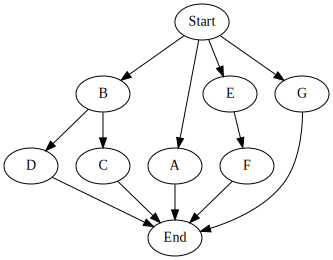

In [77]:
# Test 11:
# expected result: {'B': ['D', 'C'], 'E': ['F'], 'Start': ['B', 'A', 'E', 'G'], 'A': ['End'], 'C': ['End'], 
#                   'D': ['End'], 'F': ['End']} 
create_decision_graph('(((A|B&(C|D))|E&F)|G)')

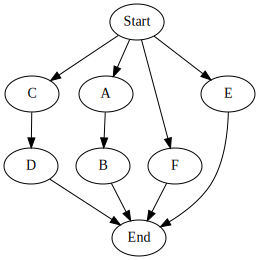

In [24]:
# Test 12
# expected result: {'A': ['B'], 'Start': ['A', 'F', 'E', 'C'], 'C': ['D'], 'B': ['End'], 'D': ['End'], 'F': ['End']}
create_decision_graph('A&B|(C&D|E)|F')

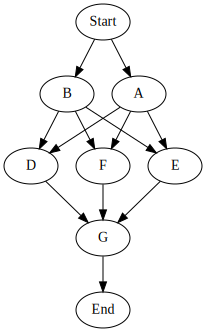

In [69]:
# Test 13
# expected result: {'B': ['F', 'E', 'D'], 'A': ['F', 'E', 'D'], 'F': ['G'], 'D': ['G'], 'E': ['G'], 
#                   'Start': ['B', 'A'], 'G': ['End']}
create_decision_graph('(A|B)&(D|E|F)&G')

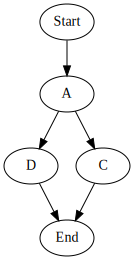

In [68]:
# Test 14
# expected result: {'A': ['D', 'C'], 'Start': ['A'], 'C': ['End'], 'D': ['End']}
create_decision_graph('(A&(C|D))')

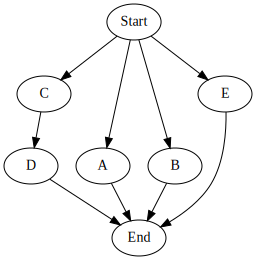

In [27]:
# Test 15
# expected result: {'Start': ['A', 'B', 'C', 'E'], 'C': ['D'], 'A': ['End'], 'B': ['End'], 'D': ['End']}
create_decision_graph('A|B|C&D|E')

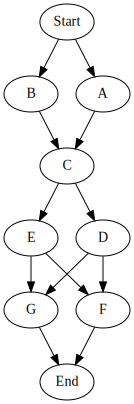

In [28]:
# Test 16
# expected result: {'B': ['C'], 'A': ['C'], 'E': ['G', 'F'], 'Start': ['B', 'A'], 'C': ['E', 'D'], 'D': ['G', 'F'],
#                   'F': ['End'], 'G': ['End]}
create_decision_graph('((A|B)&C&((D|E)&(F|G)))')

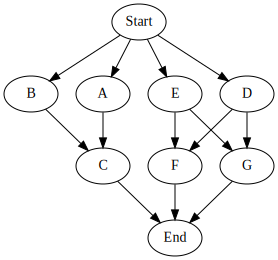

In [29]:
# Test 17
# expected result: {'B': ['C'], 'A': ['C'], 'E': ['G', 'F'], 'Start': ['B', 'A', 'E', 'D'], 'D': ['G', 'F']
#                   'C': ['End'], 'F': ['End'], 'G': ['End']}
create_decision_graph('((A|B)&C|((D|E)&(F|G)))')

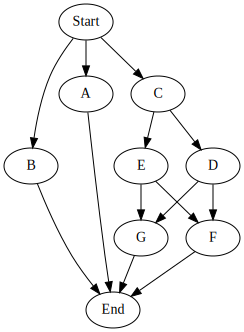

In [30]:
# Test 18
# expected result: {'E': ['G', 'F'], 'Start': ['B', 'A', 'C'], 'C': ['E', 'D'], 'D': ['G', 'F'], 'B': ['End'],
#                   'F': ['End'], 'G': ['End']}
create_decision_graph('((A|B)|C&((D|E)&(F|G)))')

In [25]:
# Test 19
# test of decision solver

s1 = 'A&B|C&D|E|F|G&H&I&J|K'

decision = Decision()
decision.extract(s1)
decision.derivation()
decision.reduce()
decision.print_testcases()

Testcase 1: 11010001110   True
Testcase 2: 10110001110   True
Testcase 3: 10101001110   True
Testcase 4: 10100101110   True
Testcase 5: 10100011110   True
Testcase 6: 10100011101   True
Testcase 7: 01010001110   False
Testcase 8: 10010001110   False
Testcase 9: 10100001110   False
Testcase 10: 10100010110   False
Testcase 11: 10100011010   False
Testcase 12: 10100011100   False
